Read in image

Get boundaries of image with bounding box

Crop image

Feed to edge detection

Feed to classification

In [1]:
import sys, os

import numpy as np

from PIL import Image, ImageFilter

import matplotlib.pyplot as plt
from   matplotlib.patches import Rectangle

import edge_feature_generation as efg
import generate_image_labels as giLabels

In [2]:
sys.path.append("/home/sean/Insight/legos/tensorbox")

import pred_location as pl

In [3]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14,10)

%matplotlib inline

In [4]:
my_df = giLabels.gen_dirty_labels()

In [5]:
my_df.head()

,img_path,label,height_brick,height_plate,height_other,shape_corner,shape_round,shape_square,short_1,short_2,...,short_6,short_8,long_1,long_2,long_3,long_4,long_6,long_8,long_10,long_12
0,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
3,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,/home/sean/Desktop/lego_images_bounding_box_di...,brick_corner_1x2x2,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
def get_img_bbox(
                    file_name    ,
                    inp_img      ,
                    box_scale=1.0,
                ):
    
    rect_list = pl.pred_lego_locations( file_name )
    
    inp_size_x = inp_img.size[0]
    inp_size_y = inp_img.size[1]
    
    fixed_rect_dict_list = []
    
    # May return multiple
    for rect in rect_list:
                
        x_mod = inp_size_x / 640.
        y_mod = inp_size_y / 480.

        # Need to expand box since fit to 640x480 image
        # Also expand borders of box 
        x_1 =  rect['x1'] * x_mod
        x_2 =  rect['x2'] * x_mod
        y_1 =  rect['y1'] * y_mod
        y_2 =  rect['y2'] * y_mod

        width = x_2 - x_1
        height= y_2 - y_1

        # Expand to the box to really make sure we have the lego
        # But make sure we don't go out of the box
        x_1 = max( x_1 + width / 2 * ( 1 - box_scale ),             0 )
        x_2 = min( x_2 - width / 2 * ( 1 - box_scale ), img.size[0]-1 )
        y_1 = max( y_1 + width / 2 * ( 1 - box_scale ),             0 ) 
        y_2 = min( y_2 - width / 2 * ( 1 - box_scale ), img.size[1]-1 )

        # Repopulate dictionary
        fixed_rect_dict_list.append(
                                    {
                                        'x1':int(x_1),
                                        'x2':int(x_2),
                                        'y1':int(y_1),
                                        'y2':int(y_2),
                                    }
                                   )
    return fixed_rect_dict_list


def plot_img_bbox(
                    inp_file,
                    bb_scale=1.0,
                    save_fig=None,
                 ):
    img = Image.open( inp_file )
    fig, ax = plt.subplots()
    ax.imshow( img )
    rect_list = get_img_bbox( file_name, img, box_scale=bb_scale )
    for rect in rect_list:
        x_1 = rect['x1']
        x_2 = rect['x2']
        y_1 = rect['y1']
        y_2 = rect['y2']
        width = x_2 - x_1
        height= y_2 - y_1
        ax.add_patch(Rectangle( 
                        (int(x_1),int(y_1)), 
                        int(width), 
                        int(height), fill=False, color='r' ) )
    if ( save_fig==None ):
        plt.show()
    else:
        plt.savefig( save_fig )
        
# Need to crop legos out of images
def crop_legos(
                inp_file_name,
                box_scale=1.0
              ):
    
    # Open the image
    inp_img = Image.open( inp_file_name )
    
    # Get the bounding boxes
    box_dict_list = get_img_bbox( inp_file_name, inp_img, box_scale=box_scale )

    # Turn into np array
    img_arr = efg.arr_from_pil( inp_img )

    # Put all the lego images in here
    img_list = []
    
    # For each box/lego found, take it
    #  out of the array
    for box in box_dict_list:
        
        # Save to a list of images
        # Images xy, np yx
        img_list.append(
                        img_arr[
                                box["y1"]:box["y2"],
                                box["x1"]:box["x2"],
                               ]
                       )
    return img_list

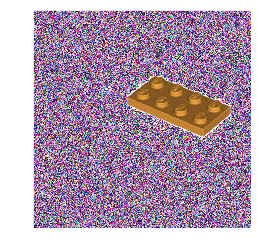

In [7]:
i = 53
file_name = my_df.loc[i,'img_path']
img = Image.open( file_name )
plt.imshow( img )
plt.show()

In [8]:
cropped_arr_list = crop_legos( file_name, box_scale=1.1 )

In [9]:
reload(efg)

<module 'edge_feature_generation' from 'edge_feature_generation.py'>

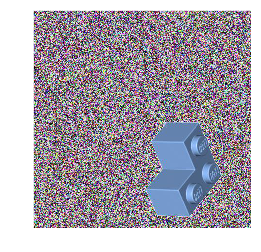

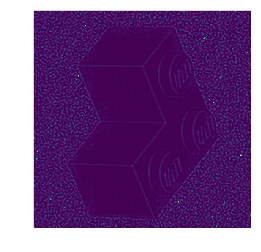

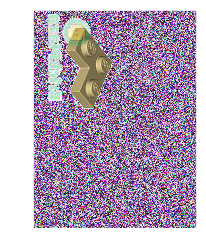

KeyboardInterrupt: 

In [11]:
# SEAN YOU NEED TO PUT A THRESHOLD ON THE EDGE DETECTION VALUES

for i in range(0,5):
    file_name = my_df.loc[i,'img_path']
    img = Image.open( file_name )
    plt.imshow( img )
    plt.show()
    
    cropped_arr_list = crop_legos( file_name, box_scale=1.1 )
    
    for img_arr in cropped_arr_list:
        rc_ratio, row_avg, col_avg = efg.get_img_edge_data( 
                                                            img_arr, 
                                                            n_color_groups=5,
                                                            tolerance=50,
                                                            edge_smooth=3,
#                                                            display=True,
#                                                            display_orientation=True
                                                          )

#    print rc_ratio
#    print row_avg[:5]
#    print col_avg[:5]

In [17]:
img_arr.shape

(215, 167, 3)

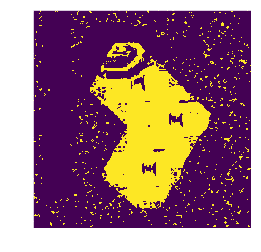

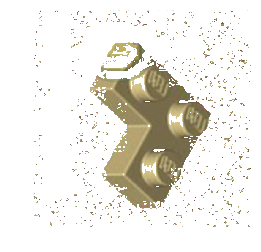

In [163]:
reload(efg)
size           = [516,516]
blur           =  5  
n_color_groups =  7
tolerance      =  20
n_mode_iter    =  30
center_size    =  0.1
display        = False
square         = False
edge_smooth    = False
display_orientation=False
edge_smooth=3

# Smooth the image
pp_img_arr = efg.resize_blur( img_arr, size, blur )


# Get indexes containing lego
color_mask, masked_arr = efg.color_select( 
                                            pp_img_arr,
                                            val_mod        = n_color_groups  ,
                                            tolerance      = tolerance       ,
                                            n_final        = n_mode_iter     ,
                                            center_bound   = center_size     ,
                                            display        = True#display         ,
                                     )

# Inclination, and axis intercept, of lego image
slope, intercept = efg.lego_orientation( 
                                        color_mask,
                                   )

# Rotate so lego horizontal
rot_arr = efg.reorient_lego( 
                            masked_arr, 
                            slope, 
                            intercept, 
                            display = (display or display_orientation),
                      )

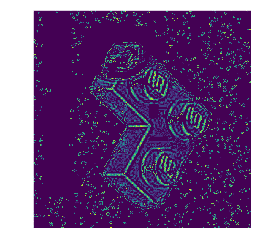

In [174]:
# Get the edges
edge_arr = efg.locate_edges( 
                            rot_arr, 
                            square=True,
                            smooth=0,
                            display=True
                       )


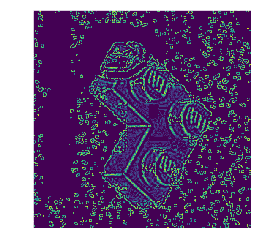

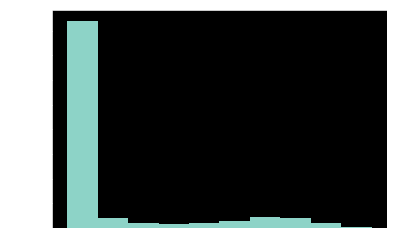

In [168]:
plt.imshow( edge_arr )
plt.show()

plt.hist( edge_arr.flatten() )
plt.show()

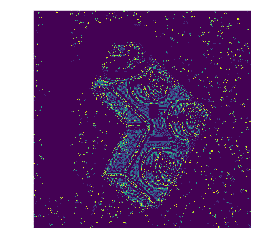

In [175]:
edge_mask = ( edge_arr > 5 )

masked_arr = edge_arr.copy()
masked_arr[edge_mask] = 0

plt.imshow( masked_arr )
plt.show()

In [92]:
def get_modes( 
                inp_arr ,
                n_final=5,
             ):
    count_dict = {}
    
    for     i in range( 0, inp_arr.shape[0] ):
        for j in range( 0, inp_arr.shape[1] ):
            
            my_key = str(inp_arr[i,j,:])
            if ( my_key in count_dict.keys() ):
                count_dict[ my_key ] = count_dict[ my_key ] + 1
            else:
                count_dict[ my_key ] = 0
        
    ret_list = []
    
    # Got the count of values, now to sort
    for key, value in sorted( count_dict.iteritems(), key=lambda (k,v): (v,k)):
        ret_list.append( key )
#        print "%s: %s" % (key, value)

    n_return = len(ret_list)//2
    return ret_list[-n_return:]

center_bound = 0.1
center_x_1 = int( pp_img_arr.shape[0]//2 - center_bound * pp_img_arr.shape[0] )
center_x_2 = int( pp_img_arr.shape[0]//2 + center_bound * pp_img_arr.shape[0] )
center_y_1 = int( pp_img_arr.shape[1]//2 - center_bound * pp_img_arr.shape[1] )
center_y_2 = int( pp_img_arr.shape[1]//2 + center_bound * pp_img_arr.shape[1] )
center_arr = pp_img_arr[
                        center_x_1:center_x_2,
                        center_y_1:center_y_2,
                        :
                    ]

common_colors = get_modes( center_arr/10 )

In [104]:
mode_list = []
for i in range( 0, len(common_colors) ):
        mode_list.append( [int(val) for val in common_colors[i].strip('[').strip(']').replace('  ',' ').split(' ')] )
mode_list = np.array( mode_list )# * val_mod

In [122]:
tolerance = 1
drop_list = []
for     i in range( 0, mode_list.shape[0], 3 ):
    for j in range( i, mode_list.shape[0] ):
        diff = abs( mode_list[i] - mode_list[j] )
        if ( ( diff < tolerance ).all() ):
            drop_list.append(i)
#            print mode_list[i]
            break
    
foo = mode_list.tolist()
for j in range( len(drop_list)-1, 0, -1 ):
    del foo[drop_list[j]]

print len( drop_list ), len( mode_list ), len(foo)


92 276 185


In [110]:
abs( np.array([1,2]) - np.array([2,2]) ) == 1

array([ True, False])